In [1]:
# Import relevant libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
from scipy import stats

# Create tickers for data download
tickers = yf.Tickers('MSFT AAPL GOOG')

# # Download price data from Yahoo Finance
df_px = yf.download(['MSFT', 'AAPL', 'GOOG'], period='2y')

# df_px.to_excel('US Stocks Prices.xlsx')
# df_px = pd.read_excel('US Stocks Prices.xlsx', index_col=0, skiprows=1)
# df_px = df_px.iloc[1: ,0:3]

# Calculate the daily returns
df_ret = df_px['Adj Close'].pct_change().iloc[1:]
# df_ret = df_px.pct_change().iloc[1:]

# 1. Historical Simulation

In [2]:
hist_var_AAPL = np.percentile(df_ret['AAPL'], 5)
hist_es_AAPL = df_ret['AAPL'][df_ret['AAPL'] <= hist_var_AAPL].mean()
print(f"VaR: {hist_var_AAPL:.4f}, Expected Shortfall: {hist_es_AAPL:.4f}")

VaR: -0.0215, Expected Shortfall: -0.0300


-0.020261470006305744 -0.026738343810922036


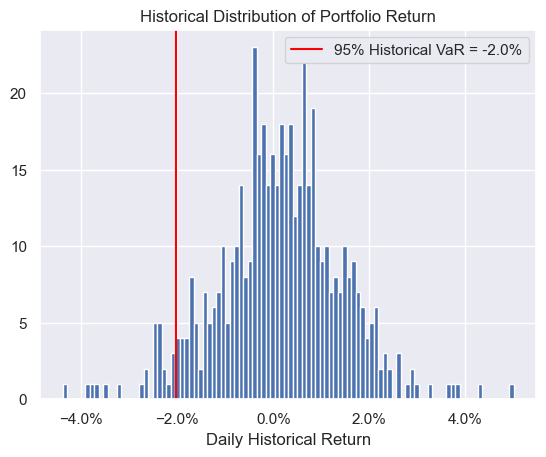

In [3]:
# Assume the weights of the stocks in the portfolio
weights = [0.2, 0.2, 0.6]
wt = np.array(weights)[:, np.newaxis]
w = wt.T

# Calculate the portfolio return
ret_port = (df_ret * w).sum(axis=1)

# Calculate the 95% Historical VaR and Expected Shortfall
hist_var = np.percentile(ret_port, 5)
hist_es = ret_port[ret_port <= hist_var].mean()
print(hist_var, hist_es)

# Plot the historical returns histogram
sns.set()
fig, ax = plt.subplots()
ax.hist(ret_port, bins=100)
ax.axvline(hist_var, color='red', label=f'95% Historical VaR = {hist_var :.1%}')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Daily Historical Return")
ax.set_title("Historical Distribution of Portfolio Return")
ax.legend()

# 2. Parametric Method

In [4]:
# Generate the variance-covariance matrix
sigma = np.array(df_ret.cov())

# Calculate the portfolio standard deviation
port_vol = np.sqrt(w @ sigma @ wt).flatten()

# Calculate the 95% VaR
para_var = (port_vol * norm.ppf(q=0.05) + ret_port.mean())

# Calculate the 95% Expected Shortfall
z_score = norm.ppf(q=0.05)
para_es = ret_port.mean() - norm.pdf(z_score)/0.05 * port_vol

print(para_var[0], para_es[0])

NameError: name 'norm' is not defined

# 3. Monte Carlo Simulation

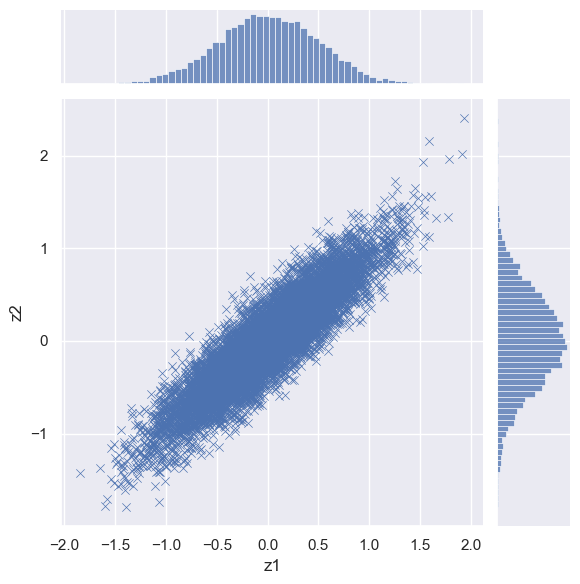

In [5]:
# Define no. of simuations
n_simulation = 10000

# Define standard deviation and correlation
sigma1  = 0.5; sigma2 = 0.5; rho = 0.9

# Construct covariance matrix
sigma_ex = np.array([[sigma1**2, rho*sigma1*sigma2],
                    [rho*sigma1*sigma2, sigma2**2]])

# Initialise the simulated returns matrix
sim_r = np.full(shape=(n_simulation,2), fill_value=0.0)

# Cholesky Decomposition
L = np.linalg.cholesky(sigma_ex)

# Set random seed
np.random.seed(100)

# Monte Carlo Simulation
for m in range(n_simulation):
    # Generate standard normal variables  
    Z = np.random.normal(size=(1,2))
    
    # Construct correlated normal
    r = np.inner(L,Z).T
    sim_r[m] = r

# Plot the distribution of the simulated returns
df_r = pd.DataFrame(sim_r)
chart = sns.jointplot(data=df_r, x=df_r[0], y=df_r[1], kind='scatter', marker='x')
chart.set_axis_labels('z1','z2')

C:\Users\tsoiy\AppData\Local\Temp\ipykernel_13060\1495561457.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


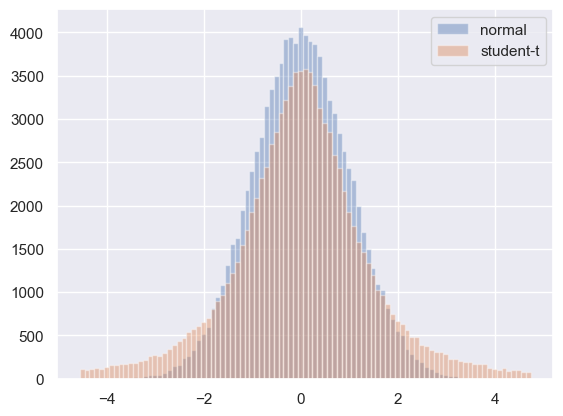

In [6]:
# Set random seed
np.random.seed(500)

# Generate standard normal and student-t simulations
Z = np.random.normal(size=(1, 100000))
t = np.random.standard_t(df=2, size=(1, 100000))

# Plot histogram
binwidth = 0.1
fig, ax = plt.subplots()
ax.hist(Z[0], bins=np.arange(min(Z[0]), max(Z[0])+binwidth, binwidth), alpha=0.4, label="normal")
ax.hist(t[0], bins=np.arange(min(Z[0]), max(Z[0])+binwidth, binwidth), alpha=0.4, label="student-t")
ax.legend()
fig.show()

In [7]:
# Define no. of simulations
n_simulation = 10000

# Initialise matrix to store simulated portfolio returns
sim_pct_change = np.full(shape=(1, n_simulation), fill_value=0.0)

# Apply Cholesky Decomposition to covariance matrix
L = np.linalg.cholesky(sigma)
meanM = np.array(df_ret.mean())[:, np.newaxis]

# Set random seed
np.random.seed(100)

for m in range(n_simulation):
    # Generate indenpedent random normal variables
    Z = np.random.normal(size=(1, len(wt)))
    
    # Generate correlated normals using the decomposed matrix
    X = np.inner(L, Z)
    
    # Shift the correlated normals by the mean returns
    daily_pct_change = meanM + X    
    
    # Calculate the simulated portfolio return
    sim_pct_change[:,m] = np.matmul(w, daily_pct_change)
    
confidence_level = 0.95
df_sim_r = pd.DataFrame(sim_pct_change.T)

# Calculate VaR and Expected Shortfall
mc_var = df_sim_r.quantile(1 - confidence_level)[0]
mc_es = df_sim_r[df_sim_r <= mc_var].mean()[0]

print(mc_var, mc_es)

-0.01935730794198071 -0.024600456605667047


In [8]:
print("APPL:", f"{stats.t.fit(df_ret['AAPL'])[0]:.2f}")
print("GOOG:", f"{stats.t.fit(df_ret['GOOG'])[0]:.2f}")
print("MSFT:", f"{stats.t.fit(df_ret['MSFT'])[0]:.2f}")

APPL: 4.94
GOOG: 4.07
MSFT: 6.54


In [9]:
# Define no. of simulations
n_simulation = 10000

# Initialise matrix to store simulated portfolio returns
sim_pct_change = np.full(shape=(1, n_simulation), fill_value=0.0)

# Apply Cholesky Decomposition to covariance matrix
L = np.linalg.cholesky(sigma)
meanM = np.array(df_ret.mean())[:, np.newaxis]

# Set random seed
np.random.seed(100)

for m in range(n_simulation):
    # Generate indenpedent random normal variables
    Z = np.random.normal(size=(1, len(wt)))
    
    # Generate correlated normals using the decomposed matrix
    X = np.inner(L, Z)
    
    # Convert the correlated normals to uniform then to Student's t
    X = stats.norm.cdf(X)   
    X = stats.t.ppf(X, df=5)
    
    # Shift the correlated normals by the mean returns
    daily_pct_change = meanM + X    
    
    # Calculate the simulated portfolio return
    sim_pct_change[:,m] = np.matmul(w, daily_pct_change)
    
confidence_level = 0.95
df_sim_r = pd.DataFrame(sim_pct_change.T)

# Calculate VaR and Expected Shortfall
mc_var_t = df_sim_r.quantile(1 - confidence_level)[0]
mc_es_t = df_sim_r[df_sim_r <= mc_var].mean()[0]

print(mc_var_t, mc_es_t)

-0.02041206892408861 -0.024918007236353408


In [10]:
print(f"VaR (normal): {mc_var:.4f}, Expected Shortfall (normal): {mc_es:.4f}")
print(f"VaR (Student's t): {mc_var_t:.4f}, Expected Shortfall (Student's t): {mc_es_t:.4f}")

VaR (normal): -0.0194, Expected Shortfall (normal): -0.0246
VaR (Student's t): -0.0204, Expected Shortfall (Student's t): -0.0249


In [11]:
# Define no. of simulations
n_simulation = 10000

# Initialise matrix to store simulated portfolio returns
sim_pct_change = np.full(shape=(1, n_simulation), fill_value=0.0)

# Apply Cholesky Decomposition to covariance matrix
L = np.linalg.cholesky(sigma)
meanM = np.array(df_ret.mean())[:, np.newaxis]

# Parmeterise the degrees of freedom using the historical portfolio return data
dof = stats.t.fit(ret_port)[0]

# Set random seed
np.random.seed(100)

for m in range(n_simulation):
    # Generate indenpedent random Student's t variables
    Z = np.random.standard_t(df=dof, size=(1, len(wt)))
    
    # Generate correlated ts using the decomposed matrix
    X = np.inner(L, Z)
       
    # Shift the correlated ts by the mean returns
    daily_pct_change = meanM + X    
    
    # Calculate the simulated portfolio return
    sim_pct_change[:,m] = np.matmul(w, daily_pct_change)
    
confidence_level = 0.95
df_sim_r = pd.DataFrame(sim_pct_change.T)

# Calculate VaR and Expected Shortfall
mc_var_tc = df_sim_r.quantile(1 - confidence_level)[0]
mc_es_tc = df_sim_r[df_sim_r <= mc_var].mean()[0]

print(mc_var_tc, mc_es_tc)

-0.022600685458326584 -0.026715513843322648


In [12]:
print(f"VaR (Gaussian - normal): {mc_var:.4f}, Expected Shortfall (Gaussian - normal): {mc_es:.4f}")
print(f"VaR (Gaussian - Student's t): {mc_var_t:.4f}, Expected Shortfall (Gaussian - Student's t): {mc_es_t:.4f}")
print(f"VaR (t-Copula): {mc_var_t:.4f}, Expected Shortfall (t-Copula): {mc_es_t:.4f}")

VaR (Gaussian - normal): -0.0194, Expected Shortfall (Gaussian - normal): -0.0246
VaR (Gaussian - Student's t): -0.0204, Expected Shortfall (Gaussian - Student's t): -0.0249
VaR (t-Copula): -0.0204, Expected Shortfall (t-Copula): -0.0249
